## Cross validation model

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,cross_val_predict
from sklearn.linear_model import RidgeClassifier
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,LabelBinarizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.linear_model import Lasso
from sklearn.utils import compute_class_weight
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_score, recall_score

# import pymc as pm
# import arviz as az



In [ ]:
import random
import math

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,LabelBinarizer,OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.linear_model import Lasso

# import pymc as pm
# import arviz as az

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from google.colab import drive


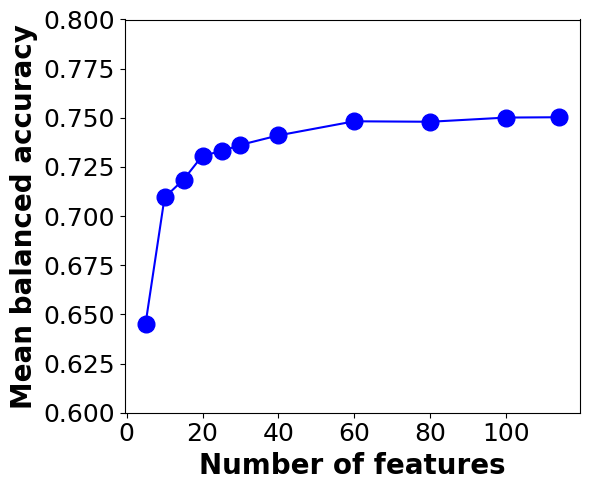

In [ ]:
# feature selection plot for figure3
# this results are taken from (Lasso regression for feature selection.ipynb) G-drive of wenyu
features = [5, 10, 15, 20, 25, 30, 40, 60, 80, 100, 114]
bal_acc = [0.6453738431888503,0.7094935801293277,0.7185717395396289,0.7307892783315812,0.7330191229474168,0.73623494796288,0.7410538475351932,0.7482282882981207,0.7479912287049028,0.7501208586238969,0.7502878430527866]

plt.figure(figsize =(6,5))
plt.plot(features, bal_acc, marker = 'o', markersize = '12' ,linestyle = '-', color = 'b')

plt.xlabel('Number of features', fontsize = '20', fontweight = 'bold' )
plt.ylabel('Mean balanced accuracy', fontsize = '20', fontweight = 'bold' )
plt.xticks( fontsize = '18' )
plt.yticks( fontsize = '18' )
plt.ylim([0.6,0.8])
#plt.title('Ridge regression with', fontsize = '16', fontweight = 'bold' )

plt.tight_layout()
#plt.show()

plt.savefig('important_feature.tiff', dpi=300)


In [ ]:
drive.mount('/content/drive')

# Set working directory
path = '/content/drive/My Drive/Tox21/'

Mounted at /content/drive


In [ ]:
# import training and test data files
X = pd.read_csv(path + 'results/X_train_rescale.csv')
y = pd.read_csv(path + 'results/y_train_rescale.csv')
Xtest = pd.read_csv(path + 'results/X_test_rescale.csv')
ytest = pd.read_csv(path + 'results/y_test_rescale.csv')

print('X_train shape',X.shape)
print('y_train shape',y.shape)
print('X_test shape',Xtest.shape)
print('y_test shape',ytest.shape)

X_train shape (287661, 40)
y_train shape (287661, 1)
X_test shape (71916, 40)
y_test shape (71916, 1)


In [ ]:
assay_train = pd.read_csv(path + 'results/assay_info_train_rescale.csv')
assay_test = pd.read_csv(path + 'results/assay_info_test_rescale.csv')
print('assay_train shape',assay_train.shape)
print('assay_test shape',assay_test.shape)

assay_train shape (287661, 7)
assay_test shape (71916, 7)


In [ ]:
X = pd.concat([X, assay_train], axis=1)
Xtest = pd.concat([Xtest, assay_test], axis=1)

In [ ]:
# saving list for performance metrics
# Training
bal_accs_t = []
auc_scores_t = []
recalls_t = []
f1s_t = []
precisions_t = []

# Validation
bal_accs_v = []
auc_scores_v = []
recalls_v = []
f1s_v = []
precisions_v = []

# Testing
bal_accs_w = []
auc_scores_w = []
f1_scores = []
recall_scores = []
precision_scores = []

# NBayes
# Training
NB_bal_accs_t = []
NB_auc_scores_t = []
NB_recalls_t = []
NB_f1s_t = []
NB_precisions_t = []

# Validation
NB_bal_accs_v = []
NB_auc_scores_v = []
NB_recalls_v = []
NB_f1s_v = []
NB_precisions_v = []

# Testing
NB_bal_accs_w = []
NB_auc_scores_w = []
NB_f1_scores = []
NB_recall_scores = []
NB_precision_scores = []

# feature_top_40 = ['FractionCSP3', 'VSA_EState3', 'SlogP_VSA10', 'PEOE_VSA14', 'fr_Al_COO',
#                   'MolLogP', 'SlogP_VSA3', 'VSA_EState9', 'VSA_EState7', 'BCUT2D_LOGPLOW',
#                   'qed', 'MinAbsEStateIndex', 'SlogP_VSA1', 'VSA_EState10',
#                   'FpDensityMorgan3', 'fr_methoxy', 'MaxAbsPartialCharge', 'BCUT2D_MWHI',
#                   'fr_ester', 'BCUT2D_MRHI', 'fr_NH1', 'fr_C_O_noCOO',
#                   'MinAbsPartialCharge', 'MinPartialCharge', 'VSA_EState5', 'TPSA',
#                   'SlogP_VSA8', 'SlogP_VSA6', 'fr_NH0', 'PEOE_VSA10', 'SlogP_VSA2',
#                   'fr_Al_OH_noTert', 'BalabanJ', 'Chi4v', 'VSA_EState1', 'VSA_EState4',
#                   'SMR_VSA4', 'fr_Ar_N', 'EState_VSA8', 'BCUT2D_CHGLO']

feature_top_40 = ['fr_C_O', 'TPSA', 'SMR_VSA1', 'NumHAcceptors', 'NumAromaticCarbocycles','NumHeteroatoms',
                  'Chi4n', 'VSA_EState10', 'VSA_EState3', 'Kappa1', 'Chi2v', 'SMR_VSA10', 'SlogP_VSA2',
                  'HallKierAlpha', 'SMR_VSA5', 'VSA_EState7', 'FractionCSP3', 'SlogP_VSA10', 'BCUT2D_LOGPLOW',
                  'VSA_EState2', 'FpDensityMorgan2', 'fr_phenol_noOrthoHbond', 'SlogP_VSA1', 'PEOE_VSA1',
                  'fr_Ar_N', 'BCUT2D_CHGLO', 'fr_ether', 'EState_VSA1', 'MinPartialCharge', 'VSA_EState6',
                  'MaxPartialCharge', 'MinAbsPartialCharge', 'VSA_EState9', 'SMR_VSA3', 'FpDensityMorgan3',
                  'SlogP_VSA12', 'fr_Al_OH_noTert', 'BalabanJ', 'MaxAbsPartialCharge', 'EState_VSA10']
for j in range(5):
    scaler = StandardScaler()
    df = X[X.columns.intersection(feature_top_40)]
    X_test = Xtest[Xtest.columns.intersection(feature_top_40)]
    y = np.array(y)
    y_test = np.array(y_test)

    X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=0.25, shuffle=True, random_state = 42)


    near_miss = RandomUnderSampler(random_state = j)
    X_train_resampled, y_train_resampled = near_miss.fit_resample(X_train, y_train)
    print(Counter(y_train_resampled))

    X_train = scaler.fit_transform(X_train_resampled)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.fit_transform(X_test)

    logistic_cv_balanced = LogisticRegressionCV(penalty='l2',Cs=10,
                                                  max_iter=10000,class_weight=None).fit(X_train, y_train_resampled)

    clf_NB = BernoulliNB().fit(X_train, y_train_resampled)


    ## model predictions
    y_train_pred = logistic_cv_balanced.predict(X_train)
    y_valid_pred = logistic_cv_balanced.predict(X_valid)
    y_test_pred = logistic_cv_balanced.predict(X_test)

    y_train_pred_prob = logistic_cv_balanced.predict_proba(X_train)[:,1]
    y_valid_pred_prob = logistic_cv_balanced.predict_proba(X_valid)[:,1]
    y_test_pred_prob = logistic_cv_balanced.predict_proba(X_test)[:,1]

    ## model performance metrics
    bal_acc_t = balanced_accuracy_score(y_train_resampled,y_train_pred)
    bal_acc_v = balanced_accuracy_score(y_valid, y_valid_pred)
    bal_acc_w = balanced_accuracy_score(y_test,y_test_pred)

    auc_score_t = metrics.roc_auc_score(y_train_resampled, y_train_pred_prob)
    auc_score_v = metrics.roc_auc_score(y_valid, y_valid_pred_prob)
    auc_score_w = metrics.roc_auc_score(y_test, y_test_pred_prob)

    recall_t = metrics.recall_score(y_train_resampled,y_train_pred)
    recall_v = metrics.recall_score(y_valid, y_valid_pred)
    recall_score = metrics.recall_score(y_test, y_test_pred)

    f1_t = metrics.f1_score(y_train_resampled,y_train_pred)
    f1_v = metrics.f1_score(y_valid, y_valid_pred)
    f1_score = metrics.f1_score(y_test, y_test_pred)

    precision_t = metrics.precision_score(y_train_resampled,y_train_pred)
    precision_v = metrics.precision_score(y_valid, y_valid_pred)
    precision_score = metrics.precision_score(y_test, y_test_pred)

    ## save perfomance
    ## Training
    bal_accs_t.append(bal_acc_t)
    auc_scores_t.append(auc_score_t)
    precisions_t.append(precision_t)
    recalls_t.append(recall_t)
    f1s_t.append(f1_t)

    ## Validation
    bal_accs_v.append(bal_acc_v)
    auc_scores_v.append(auc_score_v)
    precisions_v.append(precision_v)
    recalls_v.append(recall_v)
    f1s_v.append(f1_v)

    ## Testing
    bal_accs_w.append(bal_acc_w)
    auc_scores_w.append(auc_score_w)
    precision_scores.append(precision_score)
    recall_scores.append(recall_score)
    f1_scores.append(f1_score)



# Naive Bayes


 ## model predictions
    NB_y_train_pred = clf_NB.predict(X_train)
    NB_y_valid_pred = clf_NB.predict(X_valid)
    NB_y_test_pred = clf_NB.predict(X_test)

    NB_y_train_pred_prob = clf_NB.predict_proba(X_train)[:,1]
    NB_y_valid_pred_prob = clf_NB.predict_proba(X_valid)[:,1]
    NB_y_test_pred_prob = clf_NB.predict_proba(X_test)[:,1]

    ## model performance metrics
    NB_bal_acc_t = balanced_accuracy_score(y_train_resampled,NB_y_train_pred)
    NB_bal_acc_v = balanced_accuracy_score(y_valid, NB_y_valid_pred)
    NB_bal_acc_w = balanced_accuracy_score(y_test,NB_y_test_pred)

    NB_auc_score_t = metrics.roc_auc_score(y_train_resampled, NB_y_train_pred_prob)
    NB_auc_score_v = metrics.roc_auc_score(y_valid, NB_y_valid_pred_prob)
    NB_auc_score_w = metrics.roc_auc_score(y_test, NB_y_test_pred_prob)

    NB_recall_t = metrics.recall_score(y_train_resampled,NB_y_train_pred)
    NB_recall_v = metrics.recall_score(y_valid, NB_y_valid_pred)
    NB_recall_score = metrics.recall_score(y_test, NB_y_test_pred)

    NB_f1_t = metrics.f1_score(y_train_resampled,NB_y_train_pred)
    NB_f1_v = metrics.f1_score(y_valid, NB_y_valid_pred)
    NB_f1_score = metrics.f1_score(y_test, NB_y_test_pred)

    NB_precision_t = metrics.precision_score(y_train_resampled,NB_y_train_pred)
    NB_precision_v = metrics.precision_score(y_valid, NB_y_valid_pred)
    NB_precision_score = metrics.precision_score(y_test, NB_y_test_pred)

    ## save perfomance
    ## Training
    NB_bal_accs_t.append(NB_bal_acc_t)
    NB_auc_scores_t.append(NB_auc_score_t)
    NB_precisions_t.append(NB_precision_t)
    NB_recalls_t.append(NB_recall_t)
    NB_f1s_t.append(NB_f1_t)

    ## Validation
    NB_bal_accs_v.append(NB_bal_acc_v)
    NB_auc_scores_v.append(NB_auc_score_v)
    NB_precisions_v.append(NB_precision_v)
    NB_recalls_v.append(NB_recall_v)
    NB_f1s_v.append(NB_f1_v)

    ## Testing
    NB_bal_accs_w.append(NB_bal_acc_w)
    NB_auc_scores_w.append(NB_auc_score_w)
    NB_precision_scores.append(NB_precision_score)
    NB_recall_scores.append(NB_recall_score)
    NB_f1_scores.append(NB_f1_score)
    print(len(NB_auc_scores_t))
    print(j)

Counter({0: 21567, 1: 21567})
1
0
Counter({0: 21567, 1: 21567})
2
1
Counter({0: 21567, 1: 21567})
3
2
Counter({0: 21567, 1: 21567})
4
3
Counter({0: 21567, 1: 21567})
5
4


## NEW with NEW 40 features

In [ ]:
## Training set
print('LR_BACC=', np.mean(bal_accs_t))
print(np.std(bal_accs_t))

print('LR_auc=', np.mean(auc_scores_t))
print(np.std(auc_scores_t))

print('LR_f1=', np.mean(f1s_t))
print(np.std(f1s_t))

print('LR_recall=', np.mean(recalls_t))
print(np.std(recalls_t))

print('LR_precision=', np.mean(precisions_t))
print(np.std(precisions_t))
print('\n')

print('NB_BACC=', np.mean(NB_bal_accs_t))
print(np.std(NB_bal_accs_t))

print('NB_auc=', np.mean(NB_auc_scores_t))
print(np.std(NB_auc_scores_t))

print('NB_f1=', np.mean(NB_f1s_t))
print(np.std(NB_f1s_t))

print('NB_recall=', np.mean(NB_recalls_t))
print(np.std(NB_recalls_t))

print('NB_precision=', np.mean(NB_precisions_t))
print(np.std(NB_precisions_t))

LR_BACC= 0.736310103398711
0.0009404644969649932
LR_auc= 0.8127597976081331
0.0015638634948847501
LR_f1= 0.7359779066698124
0.0005527901642247372
LR_recall= 0.7350489173273984
0.0006644590019074797
LR_precision= 0.736912774612481
0.0016634543918408874


NB_BACC= 0.6720591644642278
0.0007491700870810153
NB_auc= 0.7381332790540951
0.0007429259743183688
NB_f1= 0.6560953326880122
0.0009147093692816299
NB_recall= 0.6256410256410256
0.0012463706675132343
NB_precision= 0.6896672909051664
0.0007899384113707409


In [ ]:
####
# Results of validation data set undersampling 75/25 split training


print('LR_BACC=', np.mean(bal_accs_v))
print(np.std(bal_accs_v))

print('LR_auc=', np.mean(auc_scores_v))
print(np.std(auc_scores_v))

print('LR_f1=', np.mean(f1s_v))
print(np.std(f1s_v))

print('LR_recall=', np.mean(recalls_v))
print(np.std(recalls_v))

print('LR_precision=', np.mean(precisions_v))
print(np.std(precisions_v))
print('\n')

print('NB_BACC=', np.mean(NB_bal_accs_v))
print(np.std(NB_bal_accs_v))

print('NB_auc=', np.mean(NB_auc_scores_v))
print(np.std(NB_auc_scores_v))

print('NB_f1=', np.mean(NB_f1s_v))
print(np.std(NB_f1s_v))

print('NB_recall=', np.mean(NB_recalls_v))
print(np.std(NB_recalls_v))

print('NB_precision=', np.mean(NB_precisions_v))
print(np.std(NB_precisions_v))

LR_BACC= 0.7380454788685642
0.0007217340164462803
LR_auc= 0.8131672818613941
0.00043044913740952865
LR_f1= 0.3577904663076027
0.001010861704018235
LR_recall= 0.7381889763779528
0.0009619027770802451
LR_precision= 0.23611734914685428
0.0008688224749868422


NB_BACC= 0.6735654987759577
0.0008720795513404597
NB_auc= 0.7383938829929606
0.0010164274781141085
NB_f1= 0.2997788415670621
0.001058213869869113
NB_recall= 0.6287401574803149
0.0010913165304798893
NB_precision= 0.19680875233321066
0.0008996787961229079


In [ ]:
#Results of test data 20% split training

print('LR_BACC=', np.mean(bal_accs_w))
# print(sem(bal_accs_w))
print(np.std(bal_accs_w))

print('LR_auc=', np.mean(auc_scores_w))
print(np.std(auc_scores_w))

print('LR_f1=', np.mean(f1_scores))
print(np.std(f1_scores))

print('LR_recall=', np.mean(recall_scores))
print(np.std(recall_scores))

print('LR_precision=', np.mean(precision_scores))
print(np.std(precision_scores))
print('\n')

print('NB_BACC=', np.mean(NB_bal_accs_w))
# print(sem(bal_accs_w))
print(np.std(NB_bal_accs_w))

print('NB_auc=', np.mean(NB_auc_scores_w))
print(np.std(NB_auc_scores_w))

print('NB_f1=', np.mean(NB_f1_scores))
print(np.std(NB_f1_scores))

print('NB_recall=', np.mean(NB_recall_scores))
print(np.std(NB_recall_scores))

print('NB_precision=', np.mean(NB_precision_scores))
print(np.std(NB_precision_scores))

LR_BACC= 0.7167448428141464
0.0009332531371041045
LR_auc= 0.8071576981396014
0.0011571380637820884
LR_f1= 0.30417120905609735
0.0008310345975763698
LR_recall= 0.869171904892047
0.0013735809645399294
LR_precision= 0.18434162710082663
0.000609969569405888


NB_BACC= 0.6756339569393628
0.0009353466870481827
NB_auc= 0.7279764719074363
0.0008760315153204403
NB_f1= 0.283373244429511
0.0006139415438153503
NB_recall= 0.7585405848592511
0.0018676523162907805
NB_precision= 0.17423099295787797
0.00037424239751697095


## Original with OLD 40 features

In [ ]:
# Results of training data undersampling 75/25 split training

print('LR_BACC=', np.mean(bal_accs_t))
print(np.std(bal_accs_t))

print('LR_auc=', np.mean(auc_scores_t))
print(np.std(auc_scores_t))

print('LR_f1=', np.mean(f1s_t))
print(np.std(f1s_t))

print('LR_recall=', np.mean(recalls_t))
print(np.std(recalls_t))

print('LR_precision=', np.mean(precisions_t))
print(np.std(precisions_t))
print('\n')

print('NB_BACC=', np.mean(NB_bal_accs_t))
print(np.std(NB_bal_accs_t))

print('NB_auc=', np.mean(NB_auc_scores_t))
print(np.std(NB_auc_scores_t))

print('NB_f1=', np.mean(NB_f1s_t))
print(np.std(NB_f1s_t))

print('NB_recall=', np.mean(NB_recalls_t))
print(np.std(NB_recalls_t))

print('NB_precision=', np.mean(NB_precisions_t))
print(np.std(NB_precisions_t))

LR_BACC= 0.734849538647007
0.0009700598614329302
LR_auc= 0.8136287433445011
0.0017116031458427553
LR_f1= 0.7304924166781308
0.0007160583027043509
LR_recall= 0.7186813186813186
0.001400993552595798
LR_precision= 0.7427041073397544
0.0018107417195455814


NB_BACC= 0.662326702833032
0.0011432484500023179
NB_auc= 0.7377566685736164
0.0008747032613345571
NB_f1= 0.6491870066273477
0.001108345024347268
NB_recall= 0.6248713312004451
0.0011126566715423034
NB_precision= 0.675472742495226
0.001382283188239408


In [ ]:
# Results of validation data set undersampling 75/25 split training


print('LR_BACC=', np.mean(bal_accs_v))
print(np.std(bal_accs_v))

print('LR_auc=', np.mean(auc_scores_v))
print(np.std(auc_scores_v))

print('LR_f1=', np.mean(f1s_v))
print(np.std(f1s_v))

print('LR_recall=', np.mean(recalls_v))
print(np.std(recalls_v))

print('LR_precision=', np.mean(precisions_v))
print(np.std(precisions_v))
print('\n')

print('NB_BACC=', np.mean(NB_bal_accs_v))
print(np.std(NB_bal_accs_v))

print('NB_auc=', np.mean(NB_auc_scores_v))
print(np.std(NB_auc_scores_v))

print('NB_f1=', np.mean(NB_f1s_v))
print(np.std(NB_f1s_v))

print('NB_recall=', np.mean(NB_recalls_v))
print(np.std(NB_recalls_v))

print('NB_precision=', np.mean(NB_precisions_v))
print(np.std(NB_precisions_v))

LR_BACC= 0.7347055730357018
0.0010066978549664782
LR_auc= 0.8142104703069684
0.00016041878234289588
LR_f1= 0.35939564481058184
0.0013205248330493164
LR_recall= 0.720753655793026
0.0018589981868434578
LR_precision= 0.23938160478221904
0.001150703631528622


NB_BACC= 0.6634141695693075
0.0011920562647315886
NB_auc= 0.736671447472413
0.0005611801188389391
NB_f1= 0.28808177691797476
0.001093437823839514
NB_recall= 0.6241001124859393
0.0017530312008446295
NB_precision= 0.18726027256198813
0.0007793340442819412


In [ ]:
#Results of test data 20% split training

print('LR_BACC=', np.mean(bal_accs_w))
# print(sem(bal_accs_w))
print(np.std(bal_accs_w))

print('LR_auc=', np.mean(auc_scores_w))
print(np.std(auc_scores_w))

print('LR_f1=', np.mean(f1_scores))
print(np.std(f1_scores))

print('LR_recall=', np.mean(recall_scores))
print(np.std(recall_scores))

print('LR_precision=', np.mean(precision_scores))
print(np.std(precision_scores))
print('\n')

print('NB_BACC=', np.mean(NB_bal_accs_w))
# print(sem(bal_accs_w))
print(np.std(NB_bal_accs_w))

print('NB_auc=', np.mean(NB_auc_scores_w))
print(np.std(NB_auc_scores_w))

print('NB_f1=', np.mean(NB_f1_scores))
print(np.std(NB_f1_scores))

print('NB_recall=', np.mean(NB_recall_scores))
print(np.std(NB_recall_scores))

print('NB_precision=', np.mean(NB_precision_scores))
print(np.std(NB_precision_scores))


LR_BACC= 0.7221844704814331
0.00017242601509746765
LR_auc= 0.8092210526724614
0.00019012296808318608
LR_f1= 0.30983555486094383
0.0002648855108484337
LR_recall= 0.8666575567094835
0.0010842762735653222
LR_precision= 0.1886374862352215
0.00023815664213571187


NB_BACC= 0.6720574160671333
0.0010285574159810836
NB_auc= 0.7317972814922024
0.0007079039119773599
NB_f1= 0.2818629011735853
0.0008685063292734036
NB_recall= 0.7459415140748838
0.0012506216112213788
NB_precision= 0.17376049254608394
0.0006313744416634414


## Model with Organism and gender

In [ ]:
# import training and test data files
X = pd.read_csv(path + 'results/X_train_rescale.csv')
y = pd.read_csv(path + 'results/y_train_rescale.csv')
Xtest = pd.read_csv(path + 'results/X_test_rescale.csv')
ytest = pd.read_csv(path + 'results/y_test_rescale.csv')

print('X_train shape',X.shape)
print('y_train shape',y.shape)
print('X_test shape',Xtest.shape)
print('y_test shape',ytest.shape)

X_train shape (287661, 40)
y_train shape (287661, 1)
X_test shape (71916, 40)
y_test shape (71916, 1)


In [ ]:
df = pd.read_csv(path + 'final_data/df_stack_50.csv')

In [ ]:
X = df.drop(columns = ['Outcome', 'Unnamed: 0'])
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=X['ProtocolName'], shuffle=True)

In [ ]:
X = X_train.iloc[:,:-7].reset_index(drop=True)
Xtest = X_test.iloc[:,:-7].reset_index(drop=True)

In [ ]:
# One-hot encoded gender and organism
label_binarizer = LabelBinarizer()
Organims = pd.DataFrame(label_binarizer.fit_transform(X_train['Organism']), columns=['Organism'])
Organims_test = pd.DataFrame(label_binarizer.transform(X_test['Organism']), columns=['Organism'])
label_binarizer = LabelBinarizer()
Gender = pd.DataFrame(label_binarizer.fit_transform(X_train['Gender']), columns=['Gender'])
Gender_test = pd.DataFrame(label_binarizer.transform(X_test['Gender']), columns=['Gender'])

In [ ]:
X = pd.concat([X, Organims, Gender], axis=1)
Xtest = pd.concat([Xtest, Organims_test, Gender_test], axis=1)
y = y_train.copy(deep=True)

In [ ]:
print('X_train shape',X.shape)
print('y_train shape',y.shape)
print('X_test shape',Xtest.shape)
print('y_test shape',y_test.shape)

X_train shape (287661, 42)
y_train shape (287661,)
X_test shape (71916, 42)
y_test shape (71916,)


In [ ]:
# saving list for performance metrics
# Training
bal_accs_t = []
auc_scores_t = []
recalls_t = []
f1s_t = []
precisions_t = []

# Validation
bal_accs_v = []
auc_scores_v = []
recalls_v = []
f1s_v = []
precisions_v = []

# Testing
bal_accs_w = []
auc_scores_w = []
f1_scores = []
recall_scores = []
precision_scores = []

# NBayes
# Training
NB_bal_accs_t = []
NB_auc_scores_t = []
NB_recalls_t = []
NB_f1s_t = []
NB_precisions_t = []

# Validation
NB_bal_accs_v = []
NB_auc_scores_v = []
NB_recalls_v = []
NB_f1s_v = []
NB_precisions_v = []

# Testing
NB_bal_accs_w = []
NB_auc_scores_w = []
NB_f1_scores = []
NB_recall_scores = []
NB_precision_scores = []

feature_top_40 = ['FractionCSP3', 'VSA_EState3', 'SlogP_VSA10', 'PEOE_VSA14', 'fr_Al_COO',
                  'MolLogP', 'SlogP_VSA3', 'VSA_EState9', 'VSA_EState7', 'BCUT2D_LOGPLOW',
                  'qed', 'MinAbsEStateIndex', 'SlogP_VSA1', 'VSA_EState10',
                  'FpDensityMorgan3', 'fr_methoxy', 'MaxAbsPartialCharge', 'BCUT2D_MWHI',
                  'fr_ester', 'BCUT2D_MRHI', 'fr_NH1', 'fr_C_O_noCOO',
                  'MinAbsPartialCharge', 'MinPartialCharge', 'VSA_EState5', 'TPSA',
                  'SlogP_VSA8', 'SlogP_VSA6', 'fr_NH0', 'PEOE_VSA10', 'SlogP_VSA2',
                  'fr_Al_OH_noTert', 'BalabanJ', 'Chi4v', 'VSA_EState1', 'VSA_EState4',
                  'SMR_VSA4', 'fr_Ar_N', 'EState_VSA8', 'BCUT2D_CHGLO', 'Gender', 'Organism']

feature_top_40 = ['fr_C_O', 'TPSA', 'SMR_VSA1', 'NumHAcceptors', 'NumAromaticCarbocycles','NumHeteroatoms',
                  'Chi4n', 'VSA_EState10', 'VSA_EState3', 'Kappa1', 'Chi2v', 'SMR_VSA10', 'SlogP_VSA2',
                  'HallKierAlpha', 'SMR_VSA5', 'VSA_EState7', 'FractionCSP3', 'SlogP_VSA10', 'BCUT2D_LOGPLOW',
                  'VSA_EState2', 'FpDensityMorgan2', 'fr_phenol_noOrthoHbond', 'SlogP_VSA1', 'PEOE_VSA1',
                  'fr_Ar_N', 'BCUT2D_CHGLO', 'fr_ether', 'EState_VSA1', 'MinPartialCharge', 'VSA_EState6',
                  'MaxPartialCharge', 'MinAbsPartialCharge', 'VSA_EState9', 'SMR_VSA3', 'FpDensityMorgan3',
                  'SlogP_VSA12', 'fr_Al_OH_noTert', 'BalabanJ', 'MaxAbsPartialCharge', 'EState_VSA10',
                  'Gender', 'Organism']
for j in range(5):
    scaler = StandardScaler()

    df = X[X.columns.intersection(feature_top_40)]
    X_test = Xtest[Xtest.columns.intersection(feature_top_40)]
    y = np.array(y)
    y_test = np.array(ytest)

    X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=0.25, shuffle=True, random_state = 42)

    # undersampling
    near_miss = RandomUnderSampler(random_state = j)
    X_train_resampled, y_train_resampled = near_miss.fit_resample(X_train, y_train)
    print(Counter(y_train_resampled))

    # normalization
    X_train = scaler.fit_transform(X_train_resampled)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.fit_transform(X_test)

    logistic_cv_balanced = LogisticRegressionCV(penalty='l2',Cs=10,
                                                  max_iter=10000,class_weight=None).fit(X_train, y_train_resampled)

    clf_NB = BernoulliNB(alpha = 50).fit(X_train, y_train_resampled)


    ## model predictions
    y_train_pred = logistic_cv_balanced.predict(X_train)
    y_valid_pred = logistic_cv_balanced.predict(X_valid)
    y_test_pred = logistic_cv_balanced.predict(X_test)

    y_train_pred_prob = logistic_cv_balanced.predict_proba(X_train)[:,1]
    y_valid_pred_prob = logistic_cv_balanced.predict_proba(X_valid)[:,1]
    y_test_pred_prob = logistic_cv_balanced.predict_proba(X_test)[:,1]

    ## model performance metrics
    bal_acc_t = balanced_accuracy_score(y_train_resampled,y_train_pred)
    bal_acc_v = balanced_accuracy_score(y_valid, y_valid_pred)
    bal_acc_w = balanced_accuracy_score(y_test,y_test_pred)

    auc_score_t = metrics.roc_auc_score(y_train_resampled, y_train_pred_prob)
    auc_score_v = metrics.roc_auc_score(y_valid, y_valid_pred_prob)
    auc_score_w = metrics.roc_auc_score(y_test, y_test_pred_prob)

    recall_t = metrics.recall_score(y_train_resampled,y_train_pred)
    recall_v = metrics.recall_score(y_valid, y_valid_pred)
    recall_score = metrics.recall_score(y_test, y_test_pred)

    f1_t = metrics.f1_score(y_train_resampled,y_train_pred)
    f1_v = metrics.f1_score(y_valid, y_valid_pred)
    f1_score = metrics.f1_score(y_test, y_test_pred)

    precision_t = metrics.precision_score(y_train_resampled,y_train_pred)
    precision_v = metrics.precision_score(y_valid, y_valid_pred)
    precision_score = metrics.precision_score(y_test, y_test_pred)

    ## save perfomance
    ## Training
    bal_accs_t.append(bal_acc_t)
    auc_scores_t.append(auc_score_t)
    precisions_t.append(precision_t)
    recalls_t.append(recall_t)
    f1s_t.append(f1_t)

    ## Validation
    bal_accs_v.append(bal_acc_v)
    auc_scores_v.append(auc_score_v)
    precisions_v.append(precision_v)
    recalls_v.append(recall_v)
    f1s_v.append(f1_v)

    ## Testing
    bal_accs_w.append(bal_acc_w)
    auc_scores_w.append(auc_score_w)
    precision_scores.append(precision_score)
    recall_scores.append(recall_score)
    f1_scores.append(f1_score)



# Naive Bayes


 ## model predictions
    NB_y_train_pred = clf_NB.predict(X_train)
    NB_y_valid_pred = clf_NB.predict(X_valid)
    NB_y_test_pred = clf_NB.predict(X_test)

    NB_y_train_pred_prob = clf_NB.predict_proba(X_train)[:,1]
    NB_y_valid_pred_prob = clf_NB.predict_proba(X_valid)[:,1]
    NB_y_test_pred_prob = clf_NB.predict_proba(X_test)[:,1]

    ## model performance metrics
    NB_bal_acc_t = balanced_accuracy_score(y_train_resampled,NB_y_train_pred)
    NB_bal_acc_v = balanced_accuracy_score(y_valid, NB_y_valid_pred)
    NB_bal_acc_w = balanced_accuracy_score(y_test,NB_y_test_pred)

    NB_auc_score_t = metrics.roc_auc_score(y_train_resampled, NB_y_train_pred_prob)
    NB_auc_score_v = metrics.roc_auc_score(y_valid, NB_y_valid_pred_prob)
    NB_auc_score_w = metrics.roc_auc_score(y_test, NB_y_test_pred_prob)

    NB_recall_t = metrics.recall_score(y_train_resampled,NB_y_train_pred)
    NB_recall_v = metrics.recall_score(y_valid, NB_y_valid_pred)
    NB_recall_score = metrics.recall_score(y_test, NB_y_test_pred)

    NB_f1_t = metrics.f1_score(y_train_resampled,NB_y_train_pred)
    NB_f1_v = metrics.f1_score(y_valid, NB_y_valid_pred)
    NB_f1_score = metrics.f1_score(y_test, NB_y_test_pred)

    NB_precision_t = metrics.precision_score(y_train_resampled,NB_y_train_pred)
    NB_precision_v = metrics.precision_score(y_valid, NB_y_valid_pred)
    NB_precision_score = metrics.precision_score(y_test, NB_y_test_pred)

    ## save perfomance
    ## Training
    NB_bal_accs_t.append(NB_bal_acc_t)
    NB_auc_scores_t.append(NB_auc_score_t)
    NB_precisions_t.append(NB_precision_t)
    NB_recalls_t.append(NB_recall_t)
    NB_f1s_t.append(NB_f1_t)

    ## Validation
    NB_bal_accs_v.append(NB_bal_acc_v)
    NB_auc_scores_v.append(NB_auc_score_v)
    NB_precisions_v.append(NB_precision_v)
    NB_recalls_v.append(NB_recall_v)
    NB_f1s_v.append(NB_f1_v)

    ## Testing
    NB_bal_accs_w.append(NB_bal_acc_w)
    NB_auc_scores_w.append(NB_auc_score_w)
    NB_precision_scores.append(NB_precision_score)
    NB_recall_scores.append(NB_recall_score)
    NB_f1_scores.append(NB_f1_score)
    print(len(NB_auc_scores_t))
    print(j)

NameError: name 'ytest' is not defined

In [ ]:
# saving list for performance metrics
# Training
bal_accs_t = []
auc_scores_t = []
recalls_t = []
f1s_t = []
precisions_t = []

# Validation
bal_accs_v = []
auc_scores_v = []
recalls_v = []
f1s_v = []
precisions_v = []

# Testing
bal_accs_w = []
auc_scores_w = []
f1_scores = []
recall_scores = []
precision_scores = []


# NBayes
# Training
NB_bal_accs_t = []
NB_auc_scores_t = []
NB_recalls_t = []
NB_f1s_t = []
NB_precisions_t = []

# Validation
NB_bal_accs_v = []
NB_auc_scores_v = []
NB_recalls_v = []
NB_f1s_v = []
NB_precisions_v = []

# Testing
NB_bal_accs_w = []
NB_auc_scores_w = []
NB_f1_scores = []
NB_recall_scores = []
NB_precision_scores = []


# Others
lambda_sig_w = []
coefs_w = []
X_tests = []
y_tests = []

# feature_top_40 = ['FractionCSP3', 'VSA_EState3', 'SlogP_VSA10', 'PEOE_VSA14', 'fr_Al_COO',
#                   'MolLogP', 'SlogP_VSA3', 'VSA_EState9', 'VSA_EState7', 'BCUT2D_LOGPLOW',
#                   'qed', 'MinAbsEStateIndex', 'SlogP_VSA1', 'VSA_EState10',
#                   'FpDensityMorgan3', 'fr_methoxy', 'MaxAbsPartialCharge', 'BCUT2D_MWHI',
#                   'fr_ester', 'BCUT2D_MRHI', 'fr_NH1', 'fr_C_O_noCOO',
#                   'MinAbsPartialCharge', 'MinPartialCharge', 'VSA_EState5', 'TPSA',
#                   'SlogP_VSA8', 'SlogP_VSA6', 'fr_NH0', 'PEOE_VSA10', 'SlogP_VSA2',
#                   'fr_Al_OH_noTert', 'BalabanJ', 'Chi4v', 'VSA_EState1', 'VSA_EState4',
#                   'SMR_VSA4', 'fr_Ar_N', 'EState_VSA8', 'BCUT2D_CHGLO', 'Gender', 'Organism']

feature_top_40 = ['fr_C_O', 'TPSA', 'SMR_VSA1', 'NumHAcceptors', 'NumAromaticCarbocycles','NumHeteroatoms',
                  'Chi4n', 'VSA_EState10', 'VSA_EState3', 'Kappa1', 'Chi2v', 'SMR_VSA10', 'SlogP_VSA2',
                  'HallKierAlpha', 'SMR_VSA5', 'VSA_EState7', 'FractionCSP3', 'SlogP_VSA10', 'BCUT2D_LOGPLOW',
                  'VSA_EState2', 'FpDensityMorgan2', 'fr_phenol_noOrthoHbond', 'SlogP_VSA1', 'PEOE_VSA1',
                  'fr_Ar_N', 'BCUT2D_CHGLO', 'fr_ether', 'EState_VSA1', 'MinPartialCharge', 'VSA_EState6',
                  'MaxPartialCharge', 'MinAbsPartialCharge', 'VSA_EState9', 'SMR_VSA3', 'FpDensityMorgan3',
                  'SlogP_VSA12', 'fr_Al_OH_noTert', 'BalabanJ', 'MaxAbsPartialCharge', 'EState_VSA10',
                  'Gender', 'Organism']
for j in range(5):
    scaler = StandardScaler()
    df = X[X.columns.intersection(feature_top_40)]
    X_test = Xtest[Xtest.columns.intersection(feature_top_40)]
    y = np.array(y)
    y_test = np.array(y_test)

    X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=0.25, shuffle=True, random_state = 42)

    near_miss = RandomUnderSampler(random_state = j)
    X_train_resampled, y_train_resampled = near_miss.fit_resample(X_train, y_train)
    print(Counter(y_train_resampled))
    print(len(X_train_resampled.columns))
    X_train = scaler.fit_transform(X_train_resampled)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.fit_transform(X_test)

    logistic_cv_balanced = LogisticRegressionCV(penalty='l2',Cs=10,
                                                  max_iter=10000,class_weight=None).fit(X_train, y_train_resampled)

    clf_NB = BernoulliNB(alpha = 50).fit(X_train, y_train_resampled)

    ## Others
    coef_w = logistic_cv_balanced.coef_[0]
    coefs_w.append(coef_w)

    X_tests.append(X_test)
    y_tests.append(y_test)

    ## model predictions
    y_train_pred = logistic_cv_balanced.predict(X_train)
    y_valid_pred = logistic_cv_balanced.predict(X_valid)
    y_test_pred = logistic_cv_balanced.predict(X_test)

    y_train_pred_prob = logistic_cv_balanced.predict_proba(X_train)[:,1]
    y_valid_pred_prob = logistic_cv_balanced.predict_proba(X_valid)[:,1]
    y_test_pred_prob = logistic_cv_balanced.predict_proba(X_test)[:,1]

    ## model performance metrics
    bal_acc_t = balanced_accuracy_score(y_train_resampled,y_train_pred)
    bal_acc_v = balanced_accuracy_score(y_valid, y_valid_pred)
    bal_acc_w = balanced_accuracy_score(y_test,y_test_pred)

    auc_score_t = metrics.roc_auc_score(y_train_resampled, y_train_pred_prob)
    auc_score_v = metrics.roc_auc_score(y_valid, y_valid_pred_prob)
    auc_score_w = metrics.roc_auc_score(y_test, y_test_pred_prob)

    recall_t = metrics.recall_score(y_train_resampled,y_train_pred)
    recall_v = metrics.recall_score(y_valid, y_valid_pred)
    recall_score = metrics.recall_score(y_test, y_test_pred)

    f1_t = metrics.f1_score(y_train_resampled,y_train_pred)
    f1_v = metrics.f1_score(y_valid, y_valid_pred)
    f1_score = metrics.f1_score(y_test, y_test_pred)

    precision_t = metrics.precision_score(y_train_resampled,y_train_pred)
    precision_v = metrics.precision_score(y_valid, y_valid_pred)
    precision_score = metrics.precision_score(y_test, y_test_pred)

    ## save perfomance
    ## Training
    bal_accs_t.append(bal_acc_t)
    auc_scores_t.append(auc_score_t)
    precisions_t.append(precision_t)
    recalls_t.append(recall_t)
    f1s_t.append(f1_t)

    ## Validation
    bal_accs_v.append(bal_acc_v)
    auc_scores_v.append(auc_score_v)
    precisions_v.append(precision_v)
    recalls_v.append(recall_v)
    f1s_v.append(f1_v)

    ## Testing
    bal_accs_w.append(bal_acc_w)
    auc_scores_w.append(auc_score_w)
    precision_scores.append(precision_score)
    recall_scores.append(recall_score)
    f1_scores.append(f1_score)




# Naive Bayes


 ## model predictions
    NB_y_train_pred = clf_NB.predict(X_train)
    NB_y_valid_pred = clf_NB.predict(X_valid)
    NB_y_test_pred = clf_NB.predict(X_test)

    NB_y_train_pred_prob = clf_NB.predict_proba(X_train)[:,1]
    NB_y_valid_pred_prob = clf_NB.predict_proba(X_valid)[:,1]
    NB_y_test_pred_prob = clf_NB.predict_proba(X_test)[:,1]

    ## model performance metrics
    NB_bal_acc_t = balanced_accuracy_score(y_train_resampled,NB_y_train_pred)
    NB_bal_acc_v = balanced_accuracy_score(y_valid, NB_y_valid_pred)
    NB_bal_acc_w = balanced_accuracy_score(y_test,NB_y_test_pred)

    NB_auc_score_t = metrics.roc_auc_score(y_train_resampled, NB_y_train_pred_prob)
    NB_auc_score_v = metrics.roc_auc_score(y_valid, NB_y_valid_pred_prob)
    NB_auc_score_w = metrics.roc_auc_score(y_test, NB_y_test_pred_prob)

    NB_recall_t = metrics.recall_score(y_train_resampled,NB_y_train_pred)
    NB_recall_v = metrics.recall_score(y_valid, NB_y_valid_pred)
    NB_recall_score = metrics.recall_score(y_test, NB_y_test_pred)

    NB_f1_t = metrics.f1_score(y_train_resampled,NB_y_train_pred)
    NB_f1_v = metrics.f1_score(y_valid, NB_y_valid_pred)
    NB_f1_score = metrics.f1_score(y_test, NB_y_test_pred)

    NB_precision_t = metrics.precision_score(y_train_resampled,NB_y_train_pred)
    NB_precision_v = metrics.precision_score(y_valid, NB_y_valid_pred)
    NB_precision_score = metrics.precision_score(y_test, NB_y_test_pred)

    ## save perfomance
    ## Training
    NB_bal_accs_t.append(NB_bal_acc_t)
    NB_auc_scores_t.append(NB_auc_score_t)
    NB_precisions_t.append(NB_precision_t)
    NB_recalls_t.append(NB_recall_t)
    NB_f1s_t.append(NB_f1_t)

    ## Validation
    NB_bal_accs_v.append(NB_bal_acc_v)
    NB_auc_scores_v.append(NB_auc_score_v)
    NB_precisions_v.append(NB_precision_v)
    NB_recalls_v.append(NB_recall_v)
    NB_f1s_v.append(NB_f1_v)

    ## Testing
    NB_bal_accs_w.append(NB_bal_acc_w)
    NB_auc_scores_w.append(NB_auc_score_w)
    NB_precision_scores.append(NB_precision_score)
    NB_recall_scores.append(NB_recall_score)
    NB_f1_scores.append(NB_f1_score)

    print(len(auc_scores_t))
    print(j)

Counter({0: 21567, 1: 21567})
42
1
0
Counter({0: 21567, 1: 21567})
42
2
1
Counter({0: 21567, 1: 21567})
42
3
2
Counter({0: 21567, 1: 21567})
42
4
3
Counter({0: 21567, 1: 21567})
42
5
4


## Generate horizontal bar plot, using absolute coefficient values

In [ ]:
coe_list = []
for i in range(5):
  coe_list.append(pd.DataFrame(coefs_w[i].tolist(), columns = [i]))

In [ ]:
coef_df = pd.concat(coe_list, axis=1)
coef_df['Features'] = feature_top_40
coef_df = coef_df.set_index('Features')
coef_df

,0,1,2,3,4
Features,,,,,
fr_C_O,8.705911,7.708438,8.056396,5.685691,7.437305
TPSA,-5.355875,-4.777621,-4.977098,-3.509925,-4.610762
SMR_VSA1,-8.082982,-7.163217,-7.447734,-5.218339,-6.854477
NumHAcceptors,-4.915254,-4.387921,-4.639844,-3.325241,-4.293176
NumAromaticCarbocycles,-0.285217,-0.309378,-0.369077,-0.449019,-0.341057
NumHeteroatoms,0.098278,0.140099,0.175589,0.278607,0.159758
Chi4n,0.228229,0.204856,0.246128,0.194065,0.196465
VSA_EState10,-0.442647,-0.447709,-0.456778,-0.451601,-0.454453
VSA_EState3,-0.144696,-0.125216,-0.148291,-0.144709,-0.138208


In [ ]:
# mean_df_abs = abs(coef_df)
mean_df_abs = coef_df.copy(deep=True)
mean_df_abs['mean_val'] = np.mean(mean_df_abs,axis=1)
mean_df_abs['std_val'] = np.std(mean_df_abs.iloc[:,:-1], axis=1)
mean_df_abs

,0,1,2,3,4,mean_val,std_val
Features,,,,,,,
fr_C_O,8.705911,7.708438,8.056396,5.685691,7.437305,7.518748,1.010063
TPSA,-5.355875,-4.777621,-4.977098,-3.509925,-4.610762,-4.646256,0.620126
SMR_VSA1,-8.082982,-7.163217,-7.447734,-5.218339,-6.854477,-6.953350,0.957556
NumHAcceptors,-4.915254,-4.387921,-4.639844,-3.325241,-4.293176,-4.312287,0.538741
NumAromaticCarbocycles,-0.285217,-0.309378,-0.369077,-0.449019,-0.341057,-0.350749,0.056732
NumHeteroatoms,0.098278,0.140099,0.175589,0.278607,0.159758,0.170466,0.059947
Chi4n,0.228229,0.204856,0.246128,0.194065,0.196465,0.213948,0.020116
VSA_EState10,-0.442647,-0.447709,-0.456778,-0.451601,-0.454453,-0.450637,0.005012
VSA_EState3,-0.144696,-0.125216,-0.148291,-0.144709,-0.138208,-0.140224,0.008179


In [ ]:
mean_df_abs.sort_values(by='mean_val')

,0,1,2,3,4,mean_val,std_val
Features,,,,,,,
SMR_VSA1,-8.082982,-7.163217,-7.447734,-5.218339,-6.854477,-6.953350,0.957556
TPSA,-5.355875,-4.777621,-4.977098,-3.509925,-4.610762,-4.646256,0.620126
NumHAcceptors,-4.915254,-4.387921,-4.639844,-3.325241,-4.293176,-4.312287,0.538741
FpDensityMorgan3,-1.015968,-0.961225,-1.018330,-0.982493,-1.027792,-1.001162,0.025166
BalabanJ,-0.842059,-0.835569,-0.843742,-0.795578,-0.856770,-0.834744,0.020757
fr_phenol_noOrthoHbond,-0.786591,-0.699684,-0.699944,-0.704245,-0.727628,-0.723618,0.033137
MinAbsPartialCharge,-0.505652,-0.540497,-0.506308,-0.510801,-0.512984,-0.515248,0.012919
Gender,-0.476258,-0.470182,-0.477623,-0.473710,-0.478517,-0.475258,0.003012
VSA_EState10,-0.442647,-0.447709,-0.456778,-0.451601,-0.454453,-0.450637,0.005012


In [ ]:
h_coe = mean_df_abs.sort_values(by=['mean_val'], ascending=True).iloc[:,-2:]
categories = []
for i in h_coe.index:
    if i.startswith('fr_'):
        categories.append('Fraction of a substructure')
    elif i.startswith('PEOE'):
        categories.append('MOE type - Partial Charges')
    elif i.startswith('SlogP'):
        categories.append('MOE type - LogP')
    elif i.startswith('SMR'):
        categories.append('MOE type - MR')
    elif i.startswith('EState') or i.startswith('VSA'):
        categories.append('MOE type - EState')
    elif i.startswith('BCUT2D'):
        categories.append('BCUT type')
    elif i.startswith('Gen'):
        categories.append('assay_meta_info')
    elif i.startswith('Org'):
        categories.append('assay_meta_info')
    else:
        categories.append('physicochemical properties')
h_coe['category'] = categories
h_coe

,mean_val,std_val,category
Features,,,
SMR_VSA1,-6.953350,0.957556,MOE type - MR
TPSA,-4.646256,0.620126,physicochemical properties
NumHAcceptors,-4.312287,0.538741,physicochemical properties
FpDensityMorgan3,-1.001162,0.025166,physicochemical properties
BalabanJ,-0.834744,0.020757,physicochemical properties
fr_phenol_noOrthoHbond,-0.723618,0.033137,Fraction of a substructure
MinAbsPartialCharge,-0.515248,0.012919,physicochemical properties
Gender,-0.475258,0.003012,assay_meta_info
VSA_EState10,-0.450637,0.005012,MOE type - EState


In [ ]:
h_coe.to_csv(path + 'Ridge_feature_imp_DS3.csv')

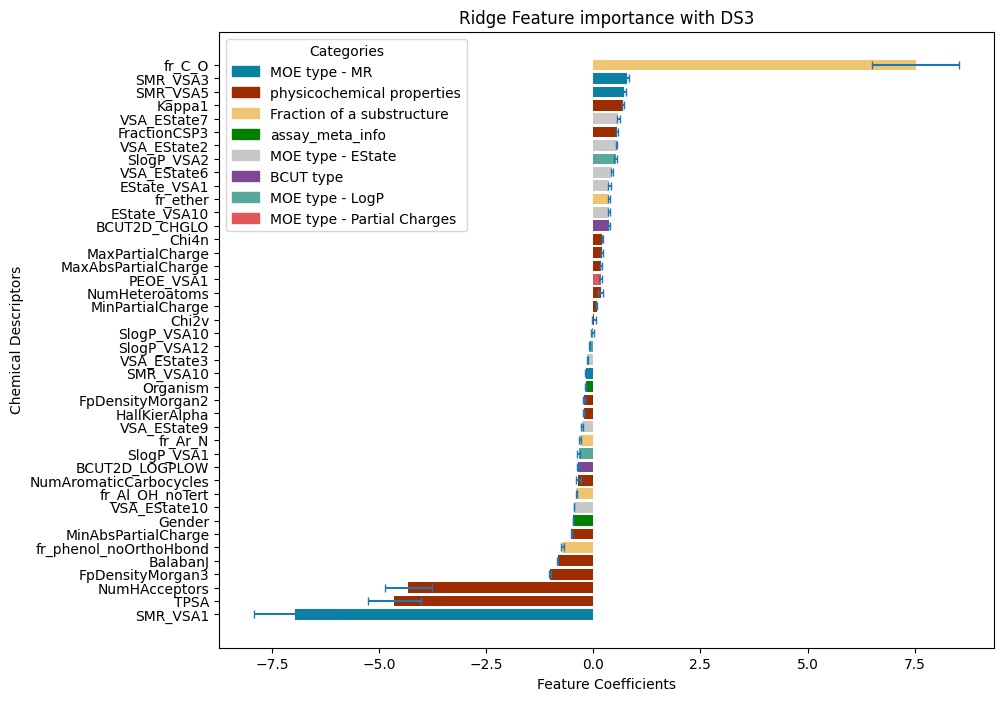

In [ ]:
h_coe_plot = h_coe.reset_index()
f, ax = plt.subplots(figsize=(10, 8))
colors = {'MOE type - EState': '#c8c8c8', 'Fraction of a substructure': '#f0c571', 'MOE type - LogP': '#59a89c',
          'MOE type - MR':'#0b81a2', 'MOE type - Partial Charges': '#e25759',
          'physicochemical properties': '#9d2c00', 'BCUT type': '#7E4794', 'assay_meta_info': 'green'}
plt.barh(data = h_coe_plot, y='Features', width='mean_val', color=[colors[i] for i in h_coe_plot.category])
plt.errorbar(data = h_coe_plot, y='Features', x='mean_val', xerr = 'std_val', fmt ='none', capsize=3)

labels = h_coe['category'].unique()
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in labels]
plt.legend(handles, labels, title="Categories")
plt.title('Ridge Feature importance with DS3')
plt.xlabel('Feature Coefficients')
plt.ylabel('Chemical Descriptors')
plt.savefig(path + 'Feature_importance_Ridge_DS3_abs_val.tiff', dpi=300, bbox_inches='tight')
plt.show()

## NEW with NEW 40 features + gender + organism

In [ ]:
# Results of training data undersampling 75/25 split training

print('LR_BACC=', np.mean(bal_accs_t))
print(np.std(bal_accs_t))

print('LR_auc=', np.mean(auc_scores_t))
print(np.std(auc_scores_t))

print('LR_f1=', np.mean(f1s_t))
print(np.std(f1s_t))

print('LR_recall=', np.mean(recalls_t))
print(np.std(recalls_t))

print('LR_precision=', np.mean(precisions_t))
print(np.std(precisions_t))
print('\n')

print('NB_BACC=', np.mean(NB_bal_accs_t))
print(np.std(NB_bal_accs_t))

print('NB_auc=', np.mean(NB_auc_scores_t))
print(np.std(NB_auc_scores_t))

print('NB_f1=', np.mean(NB_f1s_t))
print(np.std(NB_f1s_t))

print('NB_recall=', np.mean(NB_recalls_t))
print(np.std(NB_recalls_t))

print('NB_precision=', np.mean(NB_precisions_t))
print(np.std(NB_precisions_t))

LR_BACC= 0.7567951036305467
0.0012690202865951927
LR_auc= 0.8311213449464399
0.001276487527540472
LR_f1= 0.7567034537559072
0.0010343592030509967
LR_recall= 0.7564148931237539
0.0009873478298664585
LR_precision= 0.7569954014185521
0.001885458683404932


NB_BACC= 0.6777391384986322
0.0012860173770780484
NB_auc= 0.7460247988086757
0.0006764863002672195
NB_f1= 0.6627295231170074
0.0013311031986084256
NB_recall= 0.6332359623498864
0.0013377541207855025
NB_precision= 0.6951053236011451
0.0014739341904370371


In [ ]:
# Results of validation data set undersampling 75/25 split validation


print('LR_BACC=', np.mean(bal_accs_v))
print(np.std(bal_accs_v))

print('LR_auc=', np.mean(auc_scores_v))
print(np.std(auc_scores_v))

print('LR_f1=', np.mean(f1s_v))
print(np.std(f1s_v))

print('LR_recall=', np.mean(recalls_v))
print(np.std(recalls_v))

print('LR_precision=', np.mean(precisions_v))
print(np.std(precisions_v))
print('\n')

print('NB_BACC=', np.mean(NB_bal_accs_v))
print(np.std(NB_bal_accs_v))

print('NB_auc=', np.mean(NB_auc_scores_v))
print(np.std(NB_auc_scores_v))

print('NB_f1=', np.mean(NB_f1s_v))
print(np.std(NB_f1s_v))

print('NB_recall=', np.mean(NB_recalls_v))
print(np.std(NB_recalls_v))

print('NB_precision=', np.mean(NB_precisions_v))
print(np.std(NB_precisions_v))

LR_BACC= 0.7541399213716271
0.0010688331483860204
LR_auc= 0.8307199271087503
0.00025130735063758346
LR_f1= 0.37859697527183966
0.001477545337521876
LR_recall= 0.7519685039370078
0.0010634235321253579
LR_precision= 0.25298506084673456
0.0012377059140814054


NB_BACC= 0.6789564547634125
0.0006833059027502326
NB_auc= 0.7462568777955283
0.0011020993160125688
NB_f1= 0.30493594057348655
0.0007900886265043355
NB_recall= 0.6364173228346457
0.0011402213123011013
NB_precision= 0.20050355130527003
0.0006642729997581378


In [ ]:
#Results of test data 20% split training

print('LR_BACC=', np.mean(bal_accs_w))
# print(sem(bal_accs_w))
print(np.std(bal_accs_w))

print('LR_auc=', np.mean(auc_scores_w))
print(np.std(auc_scores_w))

print('LR_f1=', np.mean(f1_scores))
print(np.std(f1_scores))

print('LR_recall=', np.mean(recall_scores))
print(np.std(recall_scores))

print('LR_precision=', np.mean(precision_scores))
print(np.std(precision_scores))
print('\n')

print('NB_BACC=', np.mean(NB_bal_accs_w))
# print(sem(bal_accs_w))
print(np.std(NB_bal_accs_w))

print('NB_auc=', np.mean(NB_auc_scores_w))
print(np.std(NB_auc_scores_w))

print('NB_f1=', np.mean(NB_f1_scores))
print(np.std(NB_f1_scores))

print('NB_recall=', np.mean(NB_recall_scores))
print(np.std(NB_recall_scores))

print('NB_precision=', np.mean(NB_precision_scores))
print(np.std(NB_precision_scores))

LR_BACC= 0.7219426274758616
0.0008344837649531618
LR_auc= 0.8230113583839695
0.00043083261607129334
LR_f1= 0.30655952671096154
0.0006429971861958341
LR_recall= 0.8834654277124898
0.0012295405169939176
LR_precision= 0.18545622487335806
0.00044260059522599395


NB_BACC= 0.6825391816511276
0.000678937182753947
NB_auc= 0.7351775920420937
0.0009322025311296039
NB_f1= 0.2887517004374393
0.0005252301944406772
NB_recall= 0.7661929488931403
0.001188142395150792
NB_precision= 0.1778977065293511
0.00036526132981683316


## OLD with OLD 40 features + gender + organism

In [ ]:
# Results of training data undersampling 75/25 split training

print('LR_BACC=', np.mean(bal_accs_t))
print(np.std(bal_accs_t))

print('LR_auc=', np.mean(auc_scores_t))
print(np.std(auc_scores_t))

print('LR_f1=', np.mean(f1s_t))
print(np.std(f1s_t))

print('LR_recall=', np.mean(recalls_t))
print(np.std(recalls_t))

print('LR_precision=', np.mean(precisions_t))
print(np.std(precisions_t))
print('\n')

print('NB_BACC=', np.mean(NB_bal_accs_t))
print(np.std(NB_bal_accs_t))

print('NB_auc=', np.mean(NB_auc_scores_t))
print(np.std(NB_auc_scores_t))

print('NB_f1=', np.mean(NB_f1s_t))
print(np.std(NB_f1s_t))

print('NB_recall=', np.mean(NB_recalls_t))
print(np.std(NB_recalls_t))

print('NB_precision=', np.mean(NB_precisions_t))
print(np.std(NB_precisions_t))

LR_BACC= 0.752418046088932
0.0014584214590821877
LR_auc= 0.8324999499231932
0.0015348139246707977
LR_f1= 0.7491533974440308
0.0011696776904715266
LR_recall= 0.7393981545880279
0.0006893593931486532
LR_precision= 0.7591727722343257
0.002196549108470711


NB_BACC= 0.6731070617146566
0.0011541039764335216
NB_auc= 0.74810133590989
0.0007928605308622171
NB_f1= 0.6608847402878324
0.001164540438667022
NB_recall= 0.6370658876987991
0.0015228198261732209
NB_precision= 0.6865568726618726
0.001483358193551533


In [ ]:
# Results of validation data set undersampling 75/25 split training


print('LR_BACC=', np.mean(bal_accs_v))
print(np.std(bal_accs_v))

print('LR_auc=', np.mean(auc_scores_v))
print(np.std(auc_scores_v))

print('LR_f1=', np.mean(f1s_v))
print(np.std(f1s_v))

print('LR_recall=', np.mean(recalls_v))
print(np.std(recalls_v))

print('LR_precision=', np.mean(precisions_v))
print(np.std(precisions_v))
print('\n')

print('NB_BACC=', np.mean(NB_bal_accs_v))
print(np.std(NB_bal_accs_v))

print('NB_auc=', np.mean(NB_auc_scores_v))
print(np.std(NB_auc_scores_v))

print('NB_f1=', np.mean(NB_f1s_v))
print(np.std(NB_f1s_v))

print('NB_recall=', np.mean(NB_recalls_v))
print(np.std(NB_recalls_v))

print('NB_precision=', np.mean(NB_precisions_v))
print(np.std(NB_precisions_v))

LR_BACC= 0.7525423013022081
0.00027483952388512113
LR_auc= 0.8326305369087674
0.00015422709273801806
LR_f1= 0.3809946560327405
0.0005151950145130168
LR_recall= 0.7408323959505061
0.0008361118530550202
LR_precision= 0.25643811144179085
0.0005195968480281283


NB_BACC= 0.6735821432372802
0.0006482287156462064
NB_auc= 0.7470870571894594
0.0006032234512773941
NB_f1= 0.29787105191228674
0.0006795632000774806
NB_recall= 0.6367266591676041
0.0007983728665117008
NB_precision= 0.19440969220754525
0.0005294232070606939


In [ ]:
#Results of test data 20% split training

print('LR_BACC=', np.mean(bal_accs_w))
# print(sem(bal_accs_w))
print(np.std(bal_accs_w))

print('LR_auc=', np.mean(auc_scores_w))
print(np.std(auc_scores_w))

print('LR_f1=', np.mean(f1_scores))
print(np.std(f1_scores))

print('LR_recall=', np.mean(recall_scores))
print(np.std(recall_scores))

print('LR_precision=', np.mean(precision_scores))
print(np.std(precision_scores))
print('\n')

print('NB_BACC=', np.mean(NB_bal_accs_w))
# print(sem(bal_accs_w))
print(np.std(NB_bal_accs_w))

print('NB_auc=', np.mean(NB_auc_scores_w))
print(np.std(NB_auc_scores_w))

print('NB_f1=', np.mean(NB_f1_scores))
print(np.std(NB_f1_scores))

print('NB_recall=', np.mean(NB_recall_scores))
print(np.std(NB_recall_scores))

print('NB_precision=', np.mean(NB_precision_scores))
print(np.std(NB_precision_scores))


LR_BACC= 0.7269110888007088
0.00047068362515958486
LR_auc= 0.8259805385743846
0.00019448045738351937
LR_f1= 0.3125967250717849
0.00017523014693900102
LR_recall= 0.8765783000819896
0.001722866084993125
LR_precision= 0.19021472766943442
9.826918081366315e-05


NB_BACC= 0.6794115994324382
0.0009029213182398543
NB_auc= 0.741433470631972
0.0007023117429405709
NB_f1= 0.28750008243107333
0.0007966350443023394
NB_recall= 0.7550150314293522
0.0009522411254541703
NB_precision= 0.17755579010012182
0.0005865300550225319


## Hierarchical Bayesian Model

In [ ]:
# import training and test data files
X = pd.read_csv('X_train.csv')
y = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

print('X_train shape',X.shape)
print('y_train shape',y.shape)
print('X_test shape',X_test.shape)
print('y_test shape',y_test.shape)

X_train shape (287661, 47)
y_train shape (287661, 1)
X_test shape (71916, 47)
y_test shape (71916, 1)


In [ ]:
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
n_folds = 5
skf = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42)

In [ ]:
train_balanced_accuracy = []
test_balanced_accuracy = []

In [ ]:
For train_index, test_index in skf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]




In [ ]:
X

,MinAbsEStateIndex,qed,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_CHGLO,BCUT2D_LOGPLOW,BCUT2D_MRHI,...,fr_NH1,fr_ester,fr_methoxy,ProtocolName,Cell_Line,Tissue_Type4,Cell_Type,Gender,Organism,Tissue_Type2
0,0.027289,0.257436,-0.462953,0.462953,0.305534,1.476190,16.541564,-2.069845,-2.102449,5.688951,...,0,1,0,5,10,0,0,0,1,8
1,0.391204,0.599358,-0.297838,0.297838,0.151050,2.500000,35.496834,-1.934095,-1.789245,6.356190,...,0,0,0,22,6,1,0,0,1,3
2,0.025374,0.628503,-0.379509,0.379509,0.239058,2.826087,35.495694,-2.122549,-2.132758,7.888889,...,2,0,0,17,0,2,0,0,1,7
3,0.199653,0.688488,-0.395183,0.395183,0.056408,2.166667,79.919978,-1.938665,-2.028220,9.117385,...,0,0,0,38,6,1,0,0,1,3
4,0.135772,0.329449,-0.465580,0.465580,0.336297,2.314286,16.628496,-2.299631,-2.328121,5.994540,...,1,2,1,11,3,2,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287656,0.380028,0.803850,-0.375905,0.375905,0.144476,2.181818,35.495692,-2.296979,-2.292583,6.311055,...,0,0,0,32,5,2,0,1,1,1
287657,0.312758,0.769424,-0.496712,0.496712,0.324982,2.714286,32.133549,-2.037433,-2.185742,7.219162,...,2,0,1,49,6,1,0,0,1,3
287658,1.163704,0.509359,-0.061628,0.061628,0.025962,2.066667,79.918731,-2.050007,-1.779893,9.103965,...,0,0,0,31,11,0,0,0,1,6
287659,0.923009,0.650695,-0.300473,0.300473,0.009510,1.357143,15.156986,-2.385672,-2.416919,4.806678,...,0,0,0,0,8,2,1,1,1,4


In [ ]:
df = pd.read_csv('feature_importance_50_assay.csv')
df

,features,assay1,assay2,assay3,assay4,assay5,assay6,assay7,assay8,assay9,...,assay41,assay42,assay43,assay44,assay45,assay46,assay47,assay48,assay49,assay50
0,fr_C_O,0.274383,5.034791,9.823456,1.434788,0.744867,3.866906,4.094112,0.159230,3.541877,...,0.091582,5.680518,1.522108,3.579496,5.472050,3.112649,1.381451,2.927948,2.858702,5.232190
1,TPSA,0.180502,3.563483,6.074066,0.995836,0.496882,2.903004,2.347288,0.163744,2.142424,...,0.270930,3.197680,0.814799,2.340369,2.886423,1.883005,0.813637,1.721851,2.147953,3.197985
2,SMR_VSA1,0.265908,5.004888,9.138020,1.273737,0.651232,3.814242,3.881789,0.141934,3.182721,...,0.232711,5.039604,1.257398,3.354193,4.841662,2.835178,1.223770,2.714191,2.891211,4.897870
3,NumHAcceptors,0.213974,2.852033,5.517827,0.935944,0.441149,2.320655,2.181595,0.209424,2.113665,...,0.311969,3.162331,0.830198,2.153971,2.900625,1.927716,0.824498,1.705006,1.836431,2.848895
4,NumAromaticCarbocycles,0.327126,0.693240,0.289886,0.308193,0.453351,0.304174,0.516715,0.371962,0.336779,...,1.026345,0.203684,0.115500,0.350573,1.126650,0.449321,0.553834,0.204297,0.183375,0.128337
5,NumHeteroatoms,0.288390,0.537366,0.294376,0.234469,0.195875,0.420037,0.292417,0.254368,0.468511,...,0.558895,0.137307,0.307513,0.245905,1.080226,0.541698,0.585419,0.215220,0.407397,0.084911
6,Chi4n,0.117621,0.139148,0.161885,0.085298,0.298212,0.232013,0.321702,0.238432,0.509382,...,0.444976,0.301147,0.302495,0.219470,0.513536,0.086557,0.085261,0.135555,0.719628,0.163567
7,VSA_EState10,0.410023,0.346798,0.417056,0.515443,0.643278,0.644749,0.547574,0.395724,0.724465,...,0.794904,0.487638,0.449958,0.355811,0.884906,0.358102,0.321426,0.352565,1.164097,0.378207
8,VSA_EState3,0.135733,0.135841,0.159340,0.206597,0.151368,0.209992,0.160366,0.135060,0.242478,...,0.189913,0.192083,0.153451,0.103680,0.145004,0.177810,0.138878,0.143101,0.340802,0.177963
9,Kappa1,0.644508,0.604122,0.571766,0.572270,0.328019,0.654488,0.575220,0.428019,0.789528,...,1.119355,0.625188,0.700962,0.723613,0.873714,0.366713,0.395214,0.301013,0.963187,0.660398


In [ ]:
# Assume the dataframe is stored in a variable called df
# Create an empty dictionary to store the feature votes
feature_votes = {}

# Loop through each assay column
for i in range(1, 51):
  # Sort the dataframe by the feature importance values in descending order
  sorted_df = df.sort_values(by=f"assay{i}", ascending=False)
  # Get the name of the feature with the highest importance value
  top_feature = sorted_df["features"].iloc[0]
  # Increment the feature vote count in the dictionary
  feature_votes[top_feature] = feature_votes.get(top_feature, 0) + 1

# Create a new column in the dataframe called feature_vote
# Map the feature name to the feature vote count from the dictionary
df["feature_vote"] = df["features"].map(feature_votes)

In [ ]:
df

,features,assay1,assay2,assay3,assay4,assay5,assay6,assay7,assay8,assay9,...,assay42,assay43,assay44,assay45,assay46,assay47,assay48,assay49,assay50,feature_vote
0,fr_C_O,0.274383,5.034791,9.823456,1.434788,0.744867,3.866906,4.094112,0.159230,3.541877,...,5.680518,1.522108,3.579496,5.472050,3.112649,1.381451,2.927948,2.858702,5.232190,34.0
1,TPSA,0.180502,3.563483,6.074066,0.995836,0.496882,2.903004,2.347288,0.163744,2.142424,...,3.197680,0.814799,2.340369,2.886423,1.883005,0.813637,1.721851,2.147953,3.197985,NaN
2,SMR_VSA1,0.265908,5.004888,9.138020,1.273737,0.651232,3.814242,3.881789,0.141934,3.182721,...,5.039604,1.257398,3.354193,4.841662,2.835178,1.223770,2.714191,2.891211,4.897870,2.0
3,NumHAcceptors,0.213974,2.852033,5.517827,0.935944,0.441149,2.320655,2.181595,0.209424,2.113665,...,3.162331,0.830198,2.153971,2.900625,1.927716,0.824498,1.705006,1.836431,2.848895,NaN
4,NumAromaticCarbocycles,0.327126,0.693240,0.289886,0.308193,0.453351,0.304174,0.516715,0.371962,0.336779,...,0.203684,0.115500,0.350573,1.126650,0.449321,0.553834,0.204297,0.183375,0.128337,NaN
5,NumHeteroatoms,0.288390,0.537366,0.294376,0.234469,0.195875,0.420037,0.292417,0.254368,0.468511,...,0.137307,0.307513,0.245905,1.080226,0.541698,0.585419,0.215220,0.407397,0.084911,NaN
6,Chi4n,0.117621,0.139148,0.161885,0.085298,0.298212,0.232013,0.321702,0.238432,0.509382,...,0.301147,0.302495,0.219470,0.513536,0.086557,0.085261,0.135555,0.719628,0.163567,NaN
7,VSA_EState10,0.410023,0.346798,0.417056,0.515443,0.643278,0.644749,0.547574,0.395724,0.724465,...,0.487638,0.449958,0.355811,0.884906,0.358102,0.321426,0.352565,1.164097,0.378207,NaN
8,VSA_EState3,0.135733,0.135841,0.159340,0.206597,0.151368,0.209992,0.160366,0.135060,0.242478,...,0.192083,0.153451,0.103680,0.145004,0.177810,0.138878,0.143101,0.340802,0.177963,NaN
9,Kappa1,0.644508,0.604122,0.571766,0.572270,0.328019,0.654488,0.575220,0.428019,0.789528,...,0.625188,0.700962,0.723613,0.873714,0.366713,0.395214,0.301013,0.963187,0.660398,4.0


In [ ]:
# Assume the dataframe is stored in a variable called df
# Create an empty list to store the feature votes
feature_votes = []

# Loop through each assay column
for i in range(1, 51):
  # Sort the dataframe by the feature importance values in descending order
  sorted_df = df.sort_values(by=f"assay{i}", ascending=False)
  # Get the name of the feature with the highest importance value
  top_feature = sorted_df["features"].iloc[0]
  # Append the feature name to the feature votes list
  feature_votes.append(top_feature)

# Create a new column in the dataframe called feature_vote
# Count the frequency of each feature name in the feature votes list
df["feature_vote"] = df["features"].apply(lambda x: feature_votes.count(x))

In [ ]:
df

,features,assay1,assay2,assay3,assay4,assay5,assay6,assay7,assay8,assay9,...,assay42,assay43,assay44,assay45,assay46,assay47,assay48,assay49,assay50,feature_vote
0,fr_C_O,0.274383,5.034791,9.823456,1.434788,0.744867,3.866906,4.094112,0.159230,3.541877,...,5.680518,1.522108,3.579496,5.472050,3.112649,1.381451,2.927948,2.858702,5.232190,34
1,TPSA,0.180502,3.563483,6.074066,0.995836,0.496882,2.903004,2.347288,0.163744,2.142424,...,3.197680,0.814799,2.340369,2.886423,1.883005,0.813637,1.721851,2.147953,3.197985,0
2,SMR_VSA1,0.265908,5.004888,9.138020,1.273737,0.651232,3.814242,3.881789,0.141934,3.182721,...,5.039604,1.257398,3.354193,4.841662,2.835178,1.223770,2.714191,2.891211,4.897870,2
3,NumHAcceptors,0.213974,2.852033,5.517827,0.935944,0.441149,2.320655,2.181595,0.209424,2.113665,...,3.162331,0.830198,2.153971,2.900625,1.927716,0.824498,1.705006,1.836431,2.848895,0
4,NumAromaticCarbocycles,0.327126,0.693240,0.289886,0.308193,0.453351,0.304174,0.516715,0.371962,0.336779,...,0.203684,0.115500,0.350573,1.126650,0.449321,0.553834,0.204297,0.183375,0.128337,0
5,NumHeteroatoms,0.288390,0.537366,0.294376,0.234469,0.195875,0.420037,0.292417,0.254368,0.468511,...,0.137307,0.307513,0.245905,1.080226,0.541698,0.585419,0.215220,0.407397,0.084911,0
6,Chi4n,0.117621,0.139148,0.161885,0.085298,0.298212,0.232013,0.321702,0.238432,0.509382,...,0.301147,0.302495,0.219470,0.513536,0.086557,0.085261,0.135555,0.719628,0.163567,0
7,VSA_EState10,0.410023,0.346798,0.417056,0.515443,0.643278,0.644749,0.547574,0.395724,0.724465,...,0.487638,0.449958,0.355811,0.884906,0.358102,0.321426,0.352565,1.164097,0.378207,0
8,VSA_EState3,0.135733,0.135841,0.159340,0.206597,0.151368,0.209992,0.160366,0.135060,0.242478,...,0.192083,0.153451,0.103680,0.145004,0.177810,0.138878,0.143101,0.340802,0.177963,0
9,Kappa1,0.644508,0.604122,0.571766,0.572270,0.328019,0.654488,0.575220,0.428019,0.789528,...,0.625188,0.700962,0.723613,0.873714,0.366713,0.395214,0.301013,0.963187,0.660398,4


In [ ]:
feature_votes

['BalabanJ',
 'fr_C_O',
 'fr_C_O',
 'fr_C_O',
 'BalabanJ',
 'fr_C_O',
 'fr_C_O',
 'SMR_VSA3',
 'fr_C_O',
 'SMR_VSA3',
 'fr_C_O',
 'Kappa1',
 'Kappa1',
 'fr_C_O',
 'fr_C_O',
 'SlogP_VSA2',
 'fr_C_O',
 'fr_C_O',
 'fr_C_O',
 'fr_C_O',
 'fr_C_O',
 'fr_C_O',
 'fr_C_O',
 'fr_C_O',
 'Kappa1',
 'FpDensityMorgan3',
 'fr_C_O',
 'fr_C_O',
 'fr_C_O',
 'FpDensityMorgan3',
 'fr_C_O',
 'fr_C_O',
 'fr_C_O',
 'fr_C_O',
 'fr_C_O',
 'fr_C_O',
 'Kappa1',
 'SMR_VSA1',
 'FpDensityMorgan3',
 'SMR_VSA5',
 'fr_phenol_noOrthoHbond',
 'fr_C_O',
 'fr_C_O',
 'fr_C_O',
 'fr_C_O',
 'fr_C_O',
 'fr_C_O',
 'fr_C_O',
 'SMR_VSA1',
 'fr_C_O']